## Questions

### 1. We will consider out-of-sample predictions at x0 = (2, 2, . . . , 2). What value of f(x0) do you expect?

Because $x_{0} = (2,2,...)$ and $\beta = [2,3] + [0] * (p-2)$, we expect the value of $f (x_{0})$ to be as follows:
\begin{align*} 
\beta_{1} * 2 + \beta_{2} * 3 = 2 * 2 + 3 * 2 = 4 + 6 = 10 = f (x_{0})
\end{align*}
In the rest of this section, we convert the code to python. We start by importing the necessary libraries.

In [57]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [58]:
# Define empty dictionaries
OLS = {"prediction":[], "coefficient":[], "bias":[], "variance":[], "MSE":[]}
LASSO = {"prediction":[], "coefficient":[], "alpha":[], "bias":[], "variance":[], "MSE":[]}
RIDGE = {"prediction":[], "coefficient":[], "alpha":[], "bias":[], "variance":[], "MSE":[]}

# Simulation parameters
nsim = 100  # Number of simulations
nobs = 100  # Number of observations in each simulation
p = 10      # Number of predictors
beta = np.array([2, 3] + [0] * (p - 2))  # Coefficients: β1=2, β2=3, others=0

x0 = np.full(p, 2)  # Out-of-sample observation
# Prepare x0 for prediction (add constant and reshape for prediction)
x0 = np.insert(x0, 0, 1)  # Füge die `1` für den Intercept am Anfang ein
x0 = x0.reshape(1, -1)  # Umschreiben x0 in ein 2D-Array für die Vorhersage

# Function to simulate data
def simulate_data(nobs, p, beta, Sigma):
    X = np.random.multivariate_normal(mu, Sigma, nobs)
    noise = np.random.normal(0, 1, nobs)
    y = X @ beta + noise
    return X, y

In [59]:
# Create the first predictions for each model
for _ in range(0,nsim):
    X_example, y_example = simulate_data(nobs, p, beta, Sigma)
    X_example = sm.add_constant(X_example)  # Füge eine Konstantenspalte hinzu
    fitOLS = sm.OLS(y_example,X_example)
    model = fitOLS.fit()
    prediction = model.predict(x0)
    OLS["prediction"].append(prediction)
    OLS["coefficient"].append(model.params)

    fitLASSO = LassoCV(cv=5, random_state=42).fit(X_example,y_example)
    prediction = fitLASSO.predict(x0)
    LASSO["prediction"].append(prediction)
    LASSO["coefficient"].append(fitLASSO.coef_)
    LASSO["alpha"].append(fitLASSO.alpha_)

    fitRidge = RidgeCV(cv=5).fit(X_example,y_example)
    prediction = fitRidge.predict(x0)
    RIDGE["prediction"].append(prediction)
    RIDGE["coefficient"].append(fitRidge.coef_)
    RIDGE["alpha"].append(fitRidge.alpha_)

## 2) Run the code as is. Plot the distribution of predictions f(x0) for the different models. What do you observe?

In the below section, we plot the distributions of the three models by using histogrammes. Our results show all models share the same range of 8 to 12 in their predictions. We notice that the OLS and Ridge models display very similar distributions and share a higher variance than LASSO. The OLS has the best distribution around the mean. The other models have a small skewness.

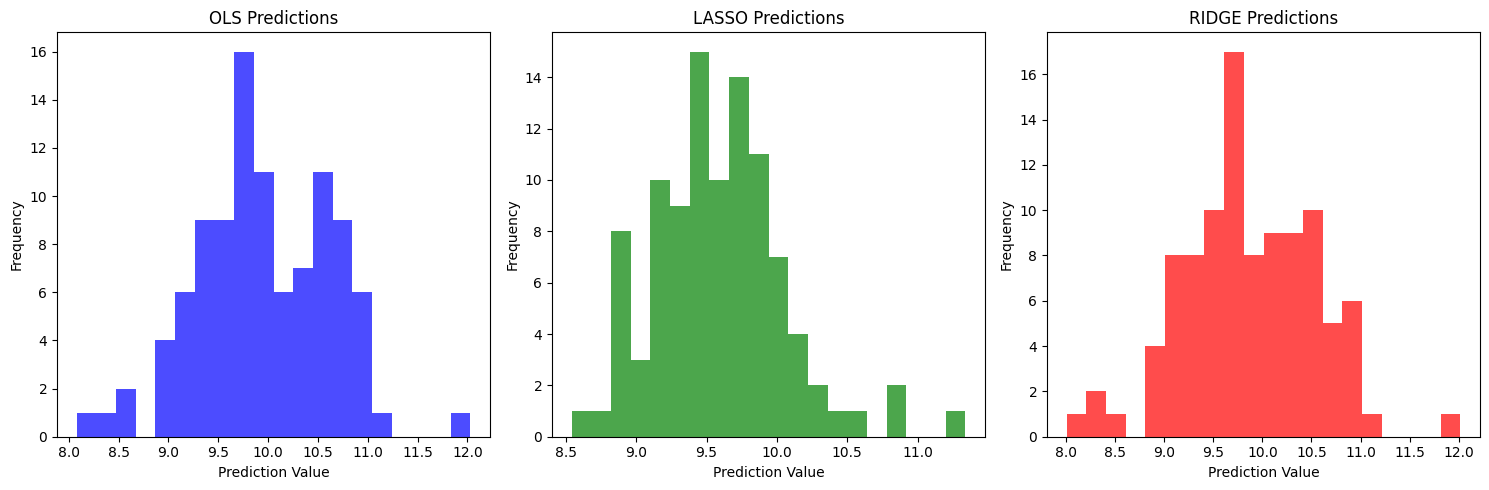

In [60]:
# Flache Arrays erstellen durch Verketten der verschachtelten Arrays
OLS["prediction"] = np.concatenate(OLS['prediction'])
LASSO['prediction'] = np.concatenate(LASSO['prediction'])
RIDGE['prediction'] = np.concatenate(RIDGE['prediction'])

# Erstellen der Histogramme
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Histogramm für OLS
axes[0].hist(OLS["prediction"], bins=20, color='blue', alpha=0.7)
axes[0].set_title('OLS Predictions')
axes[0].set_xlabel('Prediction Value')
axes[0].set_ylabel('Frequency')

# Histogramm für LASSO
axes[1].hist(LASSO['prediction'], bins=20, color='green', alpha=0.7)
axes[1].set_title('LASSO Predictions')
axes[1].set_xlabel('Prediction Value')
axes[1].set_ylabel('Frequency')

# Histogramm für RIDGE
axes[2].hist(RIDGE['prediction'], bins=20, color='red', alpha=0.7)
axes[2].set_title('RIDGE Predictions')
axes[2].set_xlabel('Prediction Value')
axes[2].set_ylabel('Frequency')

# Anzeige des Plots
plt.tight_layout()
plt.show()

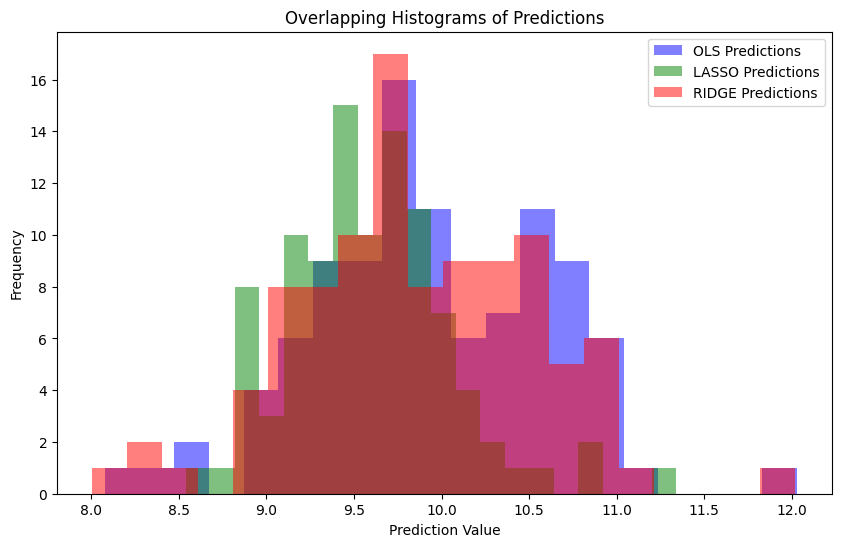

In [61]:
# Erstellen eines kombinierten Histogramms für OLS, LASSO und RIDGE Vorhersagen
plt.figure(figsize=(10, 6))

# Histogramm für OLS
plt.hist(OLS["prediction"], bins=20, color='blue', alpha=0.5, label='OLS Predictions')

# Histogramm für LASSO
plt.hist(LASSO['prediction'], bins=20, color='green', alpha=0.5, label='LASSO Predictions')

# Histogramm für RIDGE
plt.hist(RIDGE['prediction'], bins=20, color='red', alpha=0.5, label='RIDGE Predictions')

# Titel und Legende hinzufügen
plt.title('Overlapping Histograms of Predictions')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.legend()

# Anzeige des kombinierten Plots
plt.show()


To make the next steps faster, we create a "perform_simulation" function that creates the predictions with the given parameters.

In [78]:
# Mittelwertvektor und Kovarianzmatrix erstellen
mu = np.zeros(p)  # Erzeugt einen Vektor mit Nullen der Länge p
Sigma = np.eye(p)  # Erzeugt eine p x p Einheitsmatrix

# Function to simulate data
def simulate_data(nobs, p, beta, Sigma):
    mu = np.zeros(p)
    X = np.random.multivariate_normal(mu, Sigma, nobs)
    noise = np.random.normal(0, 1, nobs)
    y = X @ beta + noise
    return X, y

# Function to compute bias, variance and MSE
def compute_metrics(predictions, true_value):
    predictions = np.array(predictions).flatten()
    bias = np.mean(predictions) - true_value
    variance = np.var(predictions)
    mse = mean_squared_error(np.full_like(predictions, true_value), predictions)
    return bias, variance, mse

# Function to create a correlation matrix for correlated and uncorrelated regressors. (For Question 6)
# Regressors are not correlated when rho = 0 and correlated when rho > 0
def create_correlated_cov_matrix(p, rho):
    cov_matrix = np.full((p, p), rho)  # Jedes Element wird mit rho gefüllt
    np.fill_diagonal(cov_matrix, 1)  # Diagonalelemente auf 1 setzen, da Varianz der Prädiktoren 1 ist
    return cov_matrix

# Create predictions
# The function takes the specified parameters and performs a simulation depending on these with 3 different models
def perform_simulation(nsim, nobs, p, rho):
    beta = np.array([2, 3] + [0] * (p - 2))  # Adjust beta for p
    x0 = np.insert(np.full(p, 2), 0, 1).reshape(1, -1)  # Adjust x0 for p
    true_value = 10  # Expected true value at x0 based on the given beta and x0
    mu = np.zeros(p)  # Vector of zeros of length p
    Sigma = create_correlated_cov_matrix(p,rho)  # p x p identity matrix

    # Data structures to store results
    results = {
        "model": [],
        "p": [],
        "bias": [],
        "variance": [],
        "MSE": [],
        "nsim": [],
        "nobs": [],
        "rho": []
    }
    
    # Simulation loop
    for model_name, Model in [("OLS", sm.OLS), ("Lasso", LassoCV), ("Ridge", RidgeCV)]:
        predictions = []
        for _ in range(nsim):
            X, y = simulate_data(nobs, p, beta, Sigma)
            X = sm.add_constant(X)  # Add constant column
            if model_name in ["Lasso", "Ridge"]:
                if model_name == "Lasso":
                    model = Model(cv=5, random_state=42).fit(X, y)
                else:
                    model = Model(cv=5).fit(X, y)
                predictions.append(model.predict(x0))
            else:
                model = Model(y, X).fit()
                predictions.append(model.predict(x0))
        
        # Calculate metrics
        bias, variance, mse = compute_metrics(predictions, true_value)
        
        # Save results
        results["model"].append(model_name)
        results["p"].append(p)
        results["bias"].append(bias)
        results["variance"].append(variance)
        results["MSE"].append(mse)
        results["nsim"].append(nsim)
        results["nobs"].append(nobs)
        results["rho"].append(rho)
    
    return pd.DataFrame(results)

### 3. Compute bias, variance and mean squared error for the three different models at x0, our out-of-sample observation.

In [63]:
df_metrics = perform_simulation(nsim, nobs, p, rho=0)
df_metrics

,model,p,bias,variance,MSE,nsim,nobs,rho
0,OLS,10,-0.044575,0.486293,0.488280,100,100,0
1,Lasso,10,-0.341907,0.216095,0.332995,100,100,0
2,Ridge,10,-0.182116,0.509102,0.542269,100,100,0


### 4. How do bias and variance depend on the number of irrelevant regressors?

4. To answer this question, we run our simulation with p values starting from 10 to 100 with intervals of 20. 
As seen in the table below, we observe that:
- *Variance:*
  - In all models, the **variance** increases as the number of irrelevant regressors **increase**
  - **OLS and Ridge** face a significantly **higher increase** in variance in comparison to LASSO. This is in our opinion according to the fact, that LASSO performs a **feature selection** by setting the coefficients of irrelevant regressors to 0.
- *Bias:*
  - In all models, **bias** increases as the number of irrelevant regressors **increase.**
  - In **OLS**, the bias stays quite **constant**, whereas we see a **small increase** in bias in **LASSO**. This is in our opiniton because of the penalty term.
  - Surprisingly, **Ridge** suffers the **most** from this increase. In our opinion, this could be due to the fact that Ridge regression's penalty term becomes relatively stronger with larger **p** since Ridge regression becomes more aggressive in shrinking the coefficients towards zero, leading to a larger increase in bias compared to OLS.

In [69]:
df_results_1 = pd.DataFrame(columns=["model", "p", "bias", "variance", "MSE", "nsim", "nobs", "rho"])

for p_value in range(10, 100, 20):
    simulation_df = perform_simulation(100, 100, p_value, 0)
    df_results_1 = pd.concat([df_results_1, simulation_df], ignore_index=True)

df_results_1

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_74363/1475746318.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_1 = pd.concat([df_results_1, simulation_df], ignore_index=True)


,model,p,bias,variance,MSE,nsim,nobs,rho
0,OLS,10,-0.004152,0.425555,0.425572,100,100,0
1,Lasso,10,-0.304638,0.277418,0.370222,100,100,0
2,Ridge,10,-0.151694,0.540869,0.563880,100,100,0
3,OLS,30,-0.206839,1.778537,1.821319,100,100,0
4,Lasso,30,-0.548772,0.197954,0.499105,100,100,0
5,Ridge,30,-0.430962,1.949795,2.135523,100,100,0
6,OLS,50,-0.114134,3.292406,3.305432,100,100,0
7,Lasso,50,-0.653362,0.252390,0.679272,100,100,0
8,Ridge,50,-0.977589,3.223316,4.178997,100,100,0
9,OLS,70,0.136039,9.385513,9.404020,100,100,0


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # figsize kann angepasst werden, um eine geeignete Plotgröße zu haben

# Plot für den Bias
for model in df_results_1['model'].unique():
    df_model = df_results_1[df_results_1['model'] == model]
    ax1.plot(df_model['p'], df_model['bias'], label=model)

ax1.set_xlabel('Number of Predictors (p)')
ax1.set_ylabel('Bias')
ax1.set_title('Bias Across Different Models')
ax1.legend()
ax1.grid(True)

# Plot für die Varianz
for model in df_results_1['model'].unique():
    df_model = df_results_1[df_results_1['model'] == model]
    ax2.plot(df_model['p'], df_model['variance'], label=model)  # Annahme: Es gibt eine 'variance' Spalte

ax2.set_xlabel('Number of Predictors (p)')
ax2.set_ylabel('Variance')
ax2.set_title('Variance Across Different Models')
ax2.legend()
ax2.grid(True)

# Zeige die Plots an
plt.tight_layout()  # Verhindert das Überlappen von Subplots
plt.show()

### 5. How do bias and variance depend on the number of observations?

- *Bias*:
  - We observe that bias **becomes constant/stabilizes itself** as we increase the number of total observations. 
This effect can be seen on the line chart, around the breakpoint of **300 observations** the changes in bias become much smaller.
- *Variance*:
  - We observe that variance **decreases** as we increase the number of total observations. This effect can be seen on the line chart, the variance **decreases rapidly** until the breakpoint of **300 observations** and **slower** after this point. 

In [65]:
df_results_2 = pd.DataFrame(columns=["model", "p", "bias", "variance", "MSE", "nsim", "nobs", "rho"])

for nobs in range(100, 1000, 200):
    simulation_df = perform_simulation(100, nobs, 10, 0)
    df_results_2 = pd.concat([df_results_2, simulation_df], ignore_index=True)

df_results_2

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_74363/2025371750.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_2 = pd.concat([df_results_2, simulation_df], ignore_index=True)


,model,p,bias,variance,MSE,nsim,nobs,rho
0,OLS,10,-0.050280,0.606701,0.609229,100,100,0
1,Lasso,10,-0.385713,0.267999,0.416773,100,100,0
2,Ridge,10,0.068941,0.389537,0.394290,100,100,0
3,OLS,10,-0.079102,0.137306,0.143564,100,300,0
4,Lasso,10,-0.233571,0.067174,0.121730,100,300,0
5,Ridge,10,-0.041328,0.144306,0.146015,100,300,0
6,OLS,10,0.021295,0.085425,0.085878,100,500,0
7,Lasso,10,-0.125430,0.054013,0.069746,100,500,0
8,Ridge,10,0.005742,0.088063,0.088096,100,500,0
9,OLS,10,0.012889,0.062838,0.063005,100,700,0


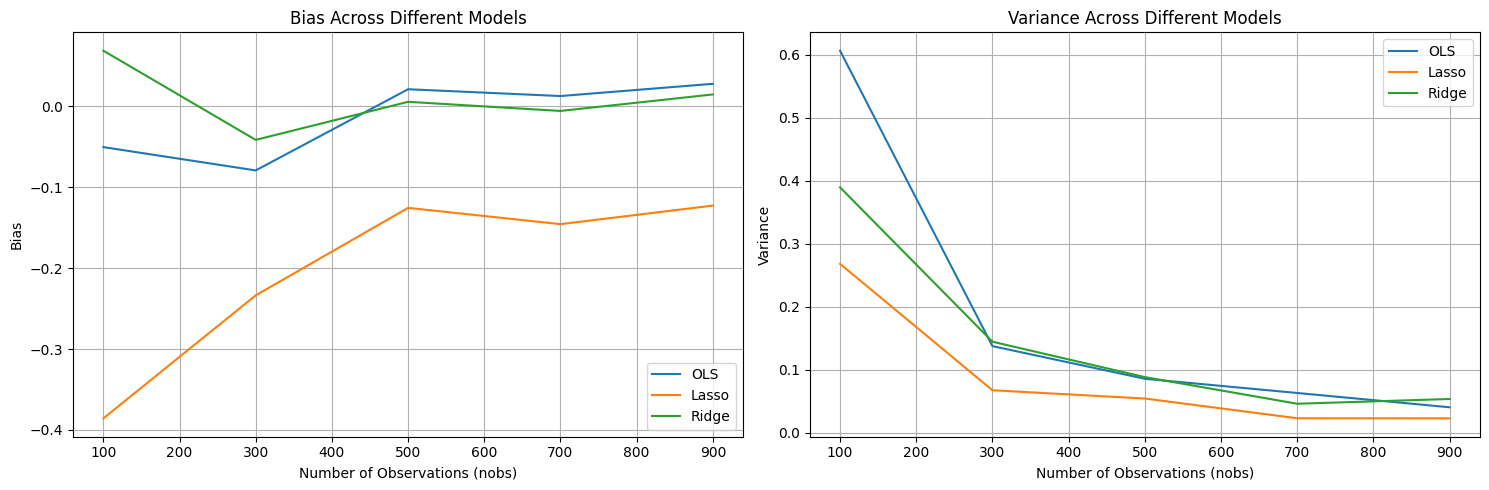

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # figsize kann angepasst werden, um eine geeignete Plotgröße zu haben

# Plot für den Bias
for model in df_results_2['model'].unique():
    df_model = df_results_2[df_results_2['model'] == model]
    ax1.plot(df_model['nobs'], df_model['bias'], label=model)

ax1.set_xlabel('Number of Observations (nobs)')
ax1.set_ylabel('Bias')
ax1.set_title('Bias Across Different Models')
ax1.legend()
ax1.grid(True)

# Plot für die Varianz
for model in df_results_2['model'].unique():
    df_model = df_results_2[df_results_2['model'] == model]
    ax2.plot(df_model['nobs'], df_model['variance'], label=model)  # Annahme: Es gibt eine 'variance' Spalte

ax2.set_xlabel('Number of Observations (nobs)')
ax2.set_ylabel('Variance')
ax2.set_title('Variance Across Different Models')
ax2.legend()
ax2.grid(True)

# Zeige die Plots an
plt.tight_layout()  # Verhindert das Überlappen von Subplots
plt.show()

### 6. The simulation above assumes that regressors are uncorrelated. How do results change when correlation between regressors is instead given by ρ > 0?

As the correlation of the parameters $\beta$ increases, it can be seen that bias and variance decrease.
OLS, Ridge: The bias remains constant over the changed correlation, indicating that the model is correctly specified.
Overall the models show better results.

Also the variance seems to decrease when correlation increases.

In [79]:
df_results_3 = pd.DataFrame(columns=["model", "p", "bias", "variance", "MSE", "nsim", "nobs", "rho"])

for rho_value in range(0, 100, 10):
    rho_value = rho_value / 100
    simulation_df = perform_simulation(100, 100, 10, rho_value)
    df_results_3 = pd.concat([df_results_3, simulation_df], ignore_index=True)

df_results_3

/var/folders/x4/q675smv52q76wfncl4h9040h0000gn/T/ipykernel_74363/3958436154.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results_3 = pd.concat([df_results_3, simulation_df], ignore_index=True)


,model,p,bias,variance,MSE,nsim,nobs,rho
0,OLS,10,-0.059828,0.388935,0.392514,100,100,0.0
1,Lasso,10,-0.365129,0.205324,0.338643,100,100,0.0
2,Ridge,10,-0.199170,0.579975,0.619643,100,100,0.0
3,OLS,10,-0.003318,0.314856,0.314867,100,100,0.1
4,Lasso,10,-0.303254,0.143031,0.234994,100,100,0.1
5,Ridge,10,-0.021273,0.318690,0.319143,100,100,0.1
6,OLS,10,0.043045,0.180016,0.181869,100,100,0.2
7,Lasso,10,-0.208991,0.113875,0.157553,100,100,0.2
8,Ridge,10,-0.050291,0.194939,0.197468,100,100,0.2
9,OLS,10,0.028246,0.128685,0.129483,100,100,0.3


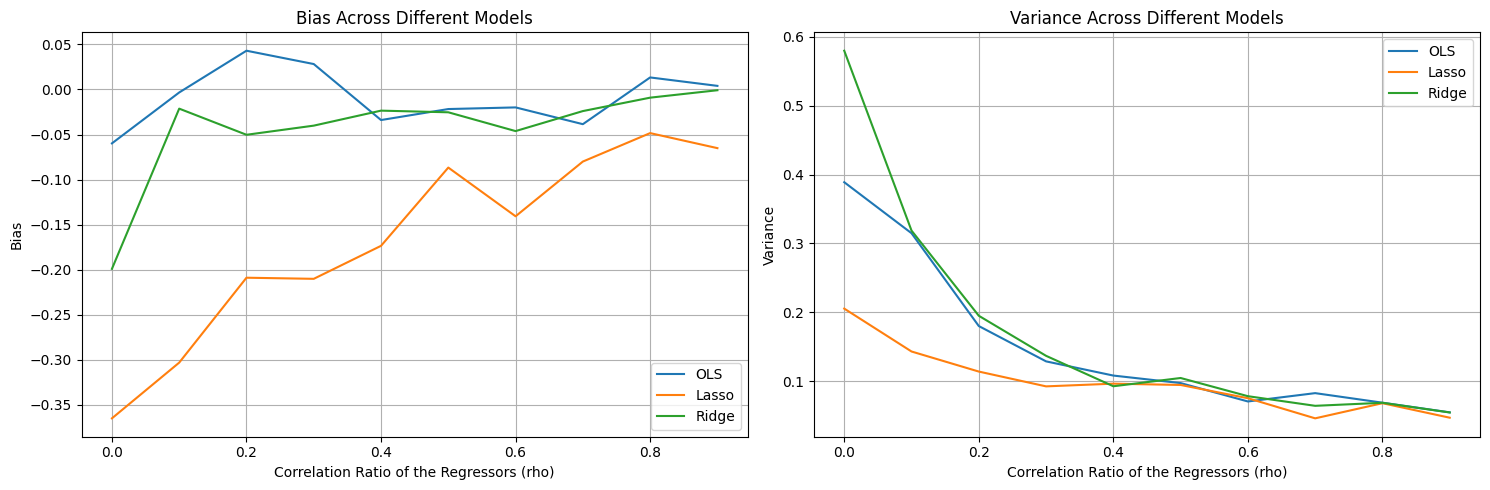

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # figsize kann angepasst werden, um eine geeignete Plotgröße zu haben

# Plot für den Bias
for model in df_results_3['model'].unique():
    df_model = df_results_3[df_results_3['model'] == model]
    ax1.plot(df_model['rho'], df_model['bias'], label=model)

ax1.set_xlabel('Correlation Ratio of the Regressors (rho)')
ax1.set_ylabel('Bias')
ax1.set_title('Bias Across Different Models')
ax1.legend()
ax1.grid(True)

# Plot für die Varianz
for model in df_results_3['model'].unique():
    df_model = df_results_3[df_results_3['model'] == model]
    ax2.plot(df_model['rho'], df_model['variance'], label=model)  # Annahme: Es gibt eine 'variance' Spalte

ax2.set_xlabel('Correlation Ratio of the Regressors (rho)')
ax2.set_ylabel('Variance')
ax2.set_title('Variance Across Different Models')
ax2.legend()
ax2.grid(True)

# Zeige die Plots an
plt.tight_layout()  # Verhindert das Überlappen von Subplots
plt.show()